In [1]:
## !pip3 install -q -r requirements.txt
# !pipreqsnb --force

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython import display

import gymnasium as gym
import numpy as np
import random

import copy

import torch
import torch.nn as nn
import tqdm.notebook as tqdm

In [2]:
from agents import ModelFreeAgent, CRandAgent, CrossEntropyNNCAgent
from aux_func import LinearAR, ExponentialAR, G_noise

## [Proceed to results](#results)

In [14]:
ENV = gym.make("Acrobot-v1", render_mode="rgb_array")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
ACTIONS_STR = ('-', '0', '+')

In [15]:
class DeepQN(ModelFreeAgent, CRandAgent):
    """
    Models internal Q-function by neural network and Bellmann equation, acts epsilon-greedy on each trajectory
    hard target, soft-target and double-DQN approaches are implemented 
    """
    def __init__(self, hidden_d=(80, 40), device=DEVICE, env=ENV, aid_to_str=ACTIONS_STR):
        super().__init__(env=env, aid_to_str=aid_to_str)

        self.loss = nn.MSELoss()
        self.device = device
        self.model = nn.Sequential(
                    nn.Linear(in_features=self.d_states, out_features=hidden_d[0]),
                    nn.ReLU(),
                    nn.Linear(in_features=hidden_d[0], out_features=hidden_d[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_d[1], self.n_actions))

        self.fly = self.dq_step 
        self.temp = [] # replay buffer
        self.frozen = self.model
        
        self.curr_eps = None # for internal use, current epsilon value
        self.curr_losses = [] # for internal use, stores loss values for current trajectory

    def freeze(self):
        """freezes current model"""
        self.frozen = copy.deepcopy(self.model)
        self.frozen.eval()

    def frozen_s(self, x, tau):
        """soft target smoothing of a moving target model with a frozen one"""
        return (1 - tau) * self.frozen(x).detach() + tau * self.model(x).detach()


    def Q(self, states):
        """current model of Q values (vector/matrix) for all actions from state/states"""
        with torch.inference_mode():
            self.model.eval()
            if states.ndim == 1: # for numpy array
                states = torch.Tensor(states).unsqueeze(0).to(self.device)
            return self.model(states).detach()

    def act(self, state):
        # use current model to get (epsilon-greedy) action distribution for next action
        action_d = self.gi(self.Q(state).squeeze().numpy(), self.curr_eps)
        return np.random.choice(self.n_actions, p=action_d)

    def dq_step(self, queue_6, done, gamma, batch_size, optimizer, tar_iter, smoothing_tau, double):
        """taking each step of a trajectory (as queue object), calculates value-function q ~ Q-learning"""
        if len(queue_6) >= 4: # sars|
            s, a, r, sx = list(queue_6)[:4]
            self.temp.append((s, a, r, sx)) # fill the storage
            if done:
                # additional xxx|sar + nan for terminal state when next action doesn't happen (but we have to retain same shape)
                self.temp.append((*list(queue_6)[3:], np.full(self.d_states, np.nan)))
            # training
            if len(self.temp) >= batch_size:
                # disjoin target modelling and new model learning
                self.freeze()
                self.model.train()
                for k in tar_iter:
                    # take batches
                    batch = random.sample(self.temp, k=batch_size)
                    # extract data from this batch and cast into a convenient shape, dtype and so on
                    states, actions, rewards, next_states = map(lambda x: torch.tensor(np.stack(x), device=self.device, requires_grad=False, dtype=torch.float), zip(*batch))
                    # apply model of Q to the elements that have valid next state only
                    done = torch.isnan(next_states).any(axis=1) # filter out rows with nans in last dimension
                    Q_next = torch.zeros(states.shape[0], 1) # pad with zeros elsewhere
                    frozen_targets = self.frozen_s(next_states[~done, :], tau=smoothing_tau)
                    if double: # apply current model to the next_states but act with argmaxes of a ~frozen one (for double-DQN)
                        Q_next[~done, :] = self.Q(next_states[~done, :])[torch.arange(frozen_targets.shape[0]), torch.argmax(frozen_targets, dim=-1)].unsqueeze(-1)
                    else:
                        Q_next[~done, :] = torch.max(frozen_targets, dim=-1, keepdim=True).values
                    # process final targets as reward + gamma * max(Q at next state)
                    Qb_d = rewards.unsqueeze(-1) + gamma * Q_next
                    # forward pass
                    Qa_d = self.model(states)[torch.arange(states.shape[0]), actions.int()].unsqueeze(-1) # Q at this state and action
                    loss = self.loss(Qa_d, Qb_d)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # save current loss value
                self.curr_losses.append(loss.detach())
            

    def fit(self, n_trajectories=100, max_length=50, lr=0.01, gamma=0.99, batch_size=4, eps_d=None, verbose=None, n_hard=1, t_soft=0, dd=False):
        """
        This algorithm performs (model of Q) learning throughout each of n_trajectories (w/ length <= max_length) 
            lr defines learning rate of built-in Adam optimizer
            verbose>0 sets up a period of learning process rendering
        NB: .fit internally uses .act method of child class(this), doesn't inherit parental
        """
        assert n_hard >= 1, f'incorrect {n_hard} amount of hard target model iterations'
            
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        iterations_pbar = tqdm.trange(n_trajectories, position=0, leave=True, colour="#a2d2ff")
        dh = display.display(display_id=True)
        # use linear annealing rule default or customize given one
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)
        eps_log, loss_log = [], []
        for i in iterations_pbar:
            # obtain epsilon
            self.curr_eps = eps_d(i)
            # trace a route
            # tar_pbar = tqdm.trange(n_hard, position=1, leave=False, colour="#ffc8dd")
            result = self.walk(max_length=max_length, gamma=gamma, batch_size=batch_size, optimizer=optimizer, tar_iter=range(n_hard), smoothing_tau=t_soft, double=dd)
            # logging
            res_reward = np.sum(result['r'])
            eps_log.append(self.curr_eps)
            self.log.append(res_reward)
            if self.curr_losses:
                loss_log.append(torch.mean(torch.stack(self.curr_losses)).item())
                iterations_pbar.set_postfix_str(f'curr reward: {res_reward.item():.0f}, loss: {loss_log[-1]:.2f}', refresh=True)
            # visualization (plotting starts after at least 1 iteration)
            if verbose and i > 0 and (i + 1) % verbose == 0:
                # print(f"iteration {i + 1}, mean total reward: {avg_reward}")
                ax = self.learning_curve(title="Rewards")
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='slateblue')
                # sns.lineplot(eps_log, linewidth=0.5, ax=ax2, label="exploration, ε", color='slateblue')
                sns.lineplot(loss_log, linewidth=0.5, ax=ax2, label="loss", color='violet')
                dh.update(plt.gcf())
                plt.close()  # because plt.clf() is spurious
        return res_reward   

  0%|          | 0/100 [00:00<?, ?it/s]

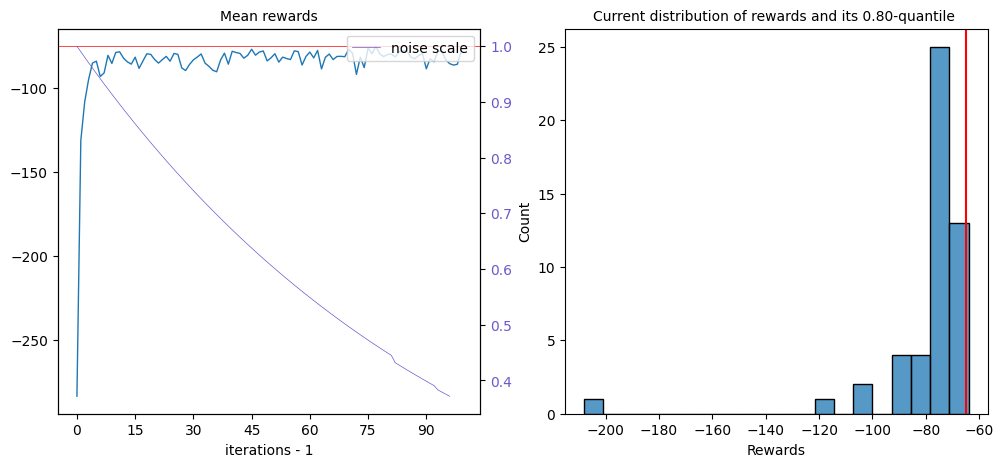

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

-77.82

In [7]:
agent_nnc = CrossEntropyNNCAgent(env=ENV, aid_to_str=ACTIONS_STR, noise_fn=G_noise)
ann_nnc_n = ExponentialAR(la=0.01, start=1, drop=1e-5)
# ann_nnc_n = SigmoidalAR(al=1e-1, start=1)
agent_nnc.fit(n_iterations=100, max_n_epochs=10, noise_scale_d=ann_nnc_n, lr=0.01, n_trajectories=50, max_length=500, q=0.8, verbose=1)

In [ ]:
dqn_base = DeepQN()
main_params = {'n_trajectories': 100, 
               'max_length': 500, 
               'lr': 0.001, 
               'gamma': 0.99999, 
               'batch_size': 64, 
               'eps_d': ExponentialAR(la=0.2), 
               'verbose': 1}
dqn_base.fit(**main_params)

  0%|          | 0/100 [00:00<?, ?it/s]

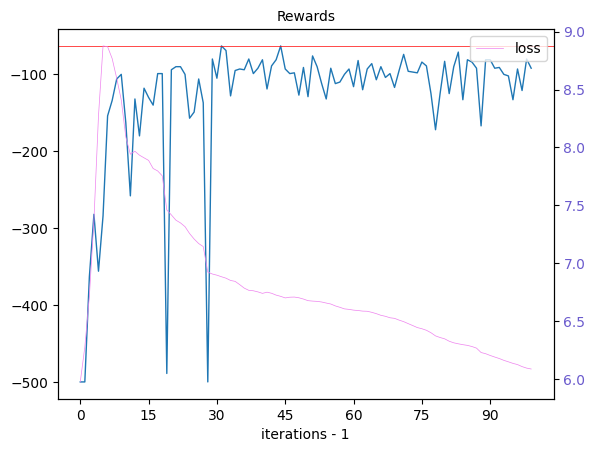

-92.0

In [12]:
dqn_hard = DeepQN()
dqn_hard.fit(**main_params, n_hard=5)

  0%|          | 0/100 [00:00<?, ?it/s]

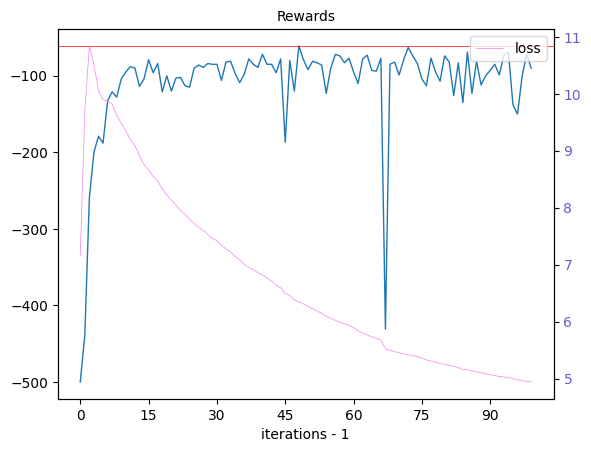

-90.0

In [13]:
dqn_soft = DeepQN()
dqn_soft.fit(**main_params, n_hard=5, t_soft=0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

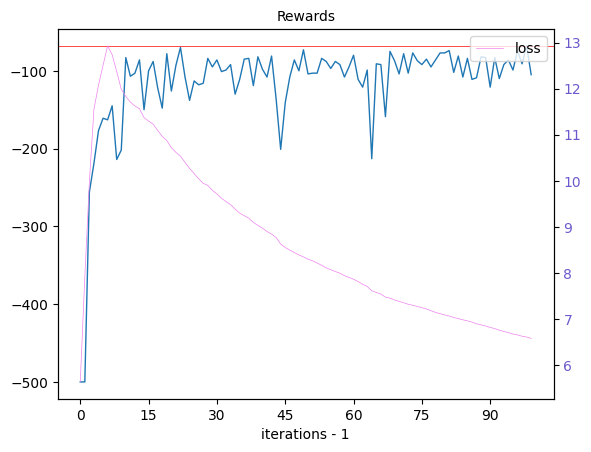

-105.0

In [16]:
dqn_dd = DeepQN()
dqn_dd.fit(**main_params, n_hard=5, t_soft=0.005, dd=True)

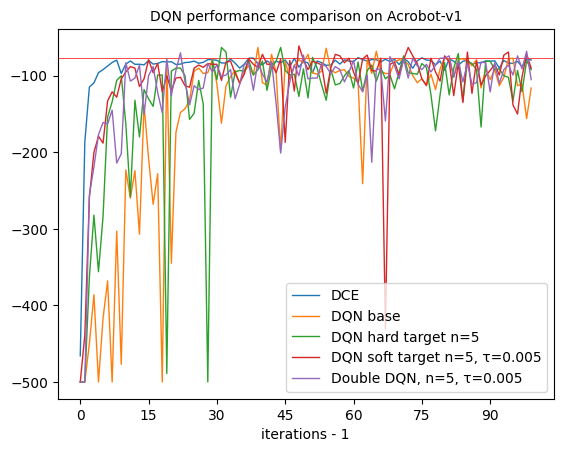

In [17]:
ax = agent_nnc.learning_curve(label='DCE')
ax = dqn_base.learning_curve(ax=ax, label='DQN base', show_max=False)
ax = dqn_hard.learning_curve(ax=ax, label='DQN hard target n=5', show_max=False)
ax = dqn_soft.learning_curve(ax=ax, label='DQN soft target n=5, τ=0.005', show_max=False)
ax = dqn_dd.learning_curve(ax=ax, label='Double DQN, n=5, τ=0.005', show_max=False, title='DQN performance comparison on Acrobot-v1')

# Results 
<a id="results"></a>
All algorithms have been implemented successfully and tested on Acrobot environment 

My implementation combines basic DQN algorithm (subclassed from ModelFree class), all improvements are built-in:
- Experience replay buffer
- Hard Target (controlled by number of iterations with same target)
- Soft Target (controlled by tau factor)
- Double DQN

My key finding was that the loss value in reinforcement learning is insignificant. As far as I understand it, that behaviour is caused by moving target issue. Despite a direct goal of GD algorithm is always to decrease loss (not to increase rewards), both of those should happen eventually, it's just a coincidence that we get high enough rewards first

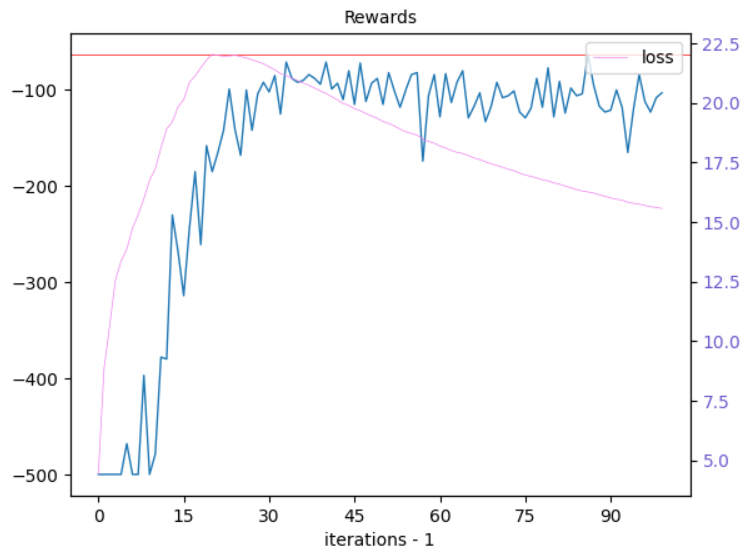

## Hyperparameter search

I use 100 iterations as most of aforementioned algorithms do converge within those

### Batch size
Doesn't have any major impact on convergence except its stability

### Gamma
Acrobot environment appreciates rather high values of gamma like $\gamma = 0.99999$, anything lower than $0.99$ makes things worse

### NN architecture and so on
Has not been investigated thoroughly, but 2 layers with anything like 50...100 hidden layer(s) neurons should be capable of performing well enough

Mean squared error loss is ok for this task, I haven't found any reasons in favor of other losses

### Exploration rate 
I figured out that both Acrobot and CartPole environments perform much better with fast exponential decay for 
$$\epsilon=1*\exp(-\lambda * i), \quad i=1\dots 100, \lambda=0.2$$
that may bring some stochasticity into the following results but still ok

### Learning rate
I used $lr=0.001$ for 2-layer networks, tends to be an optimal lr for this task cause everything breaks (explodes) with higher lr

## Comparison with DCE
I used hyperparameters from a previous task for CE and it definitely brings much better convergence: despite its iterations are not directly comparable with those of DQN, they are obviously less stochastic

### Hard-target
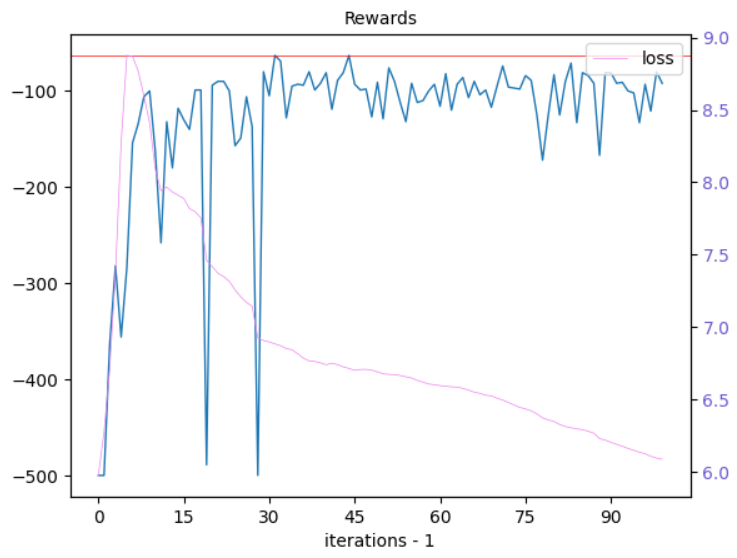

Large amount of iterations slows down the whole process significantly but doesn't bring good convergence at the end anyway, therefore I will stick to n_hard=5
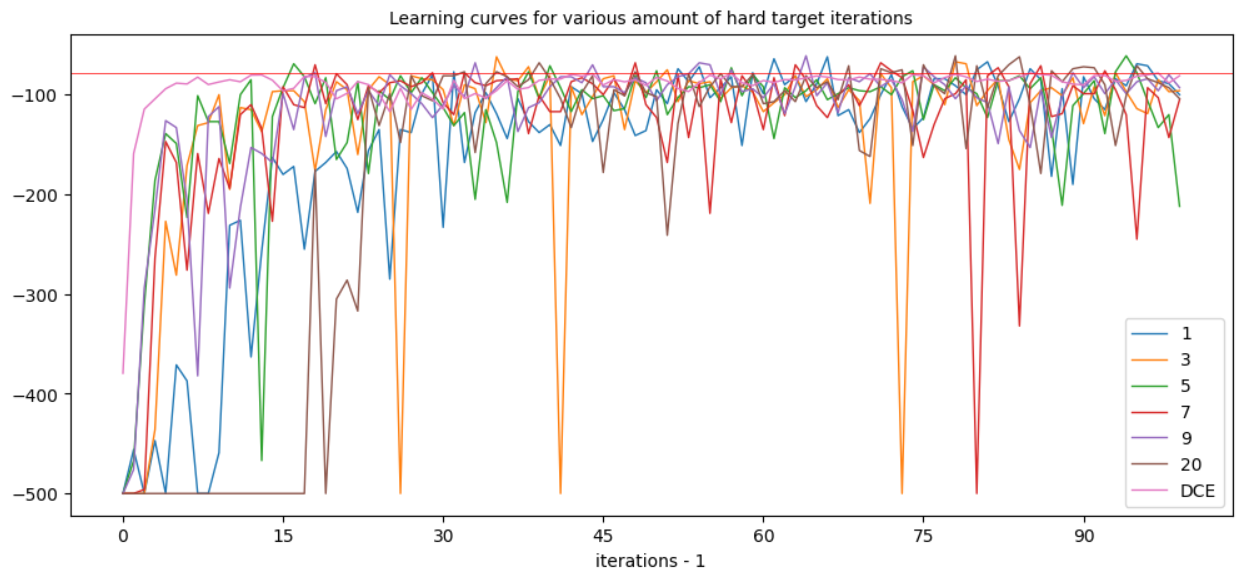

### Soft-target
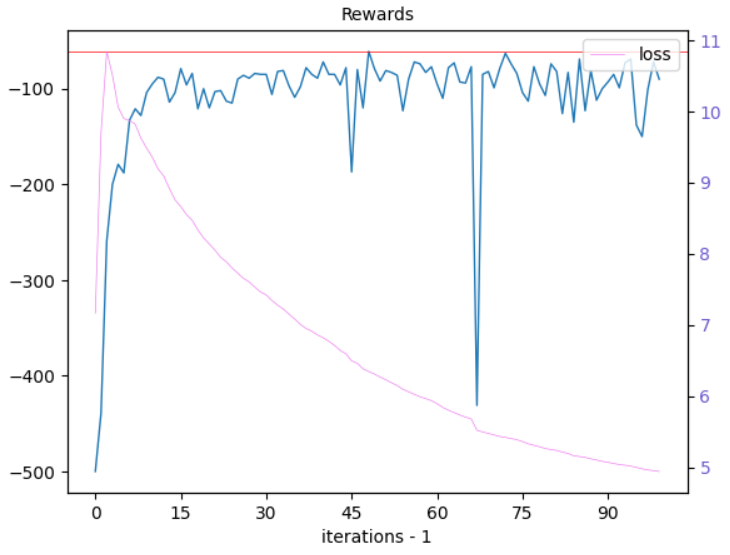

Well, it seems that there is no clear statistically meaningful difference in smoothing factor choice (at least for this scale and time constraints)

I am going to take less chaotic $\tau = 0.005$, i.e. vary frozen target model with 0.5% of new model at each DQN w/ hard target step
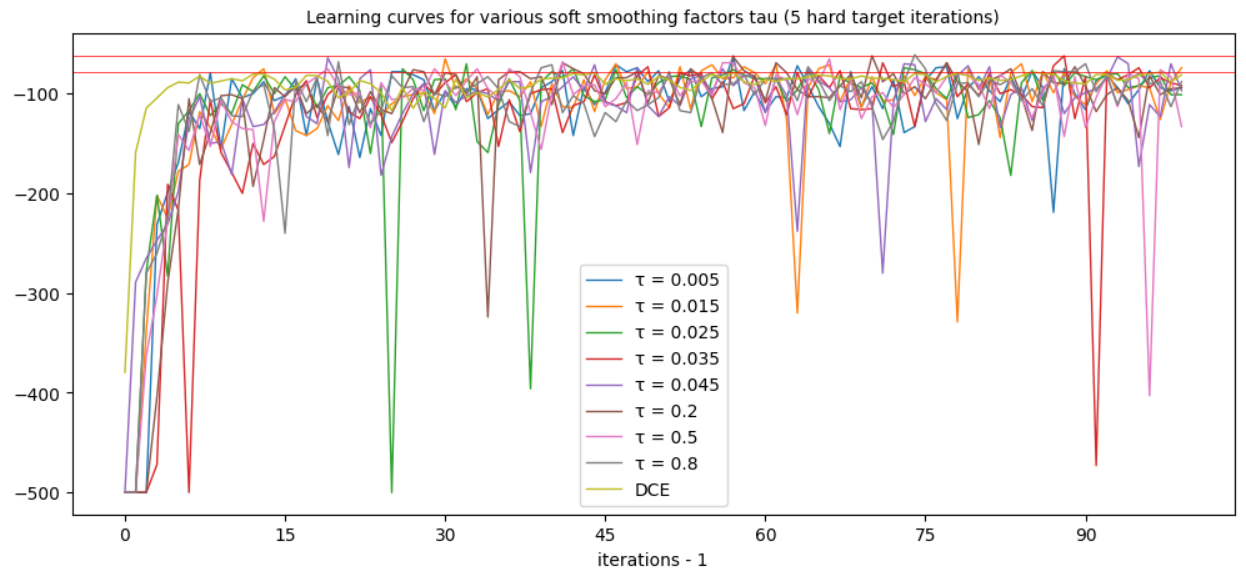

### Double DQN

Double DQN is capable of yielding higher max rewards but doesn't really saturate there; his iterations suffer from random spikes of high magnitude unlike the rest

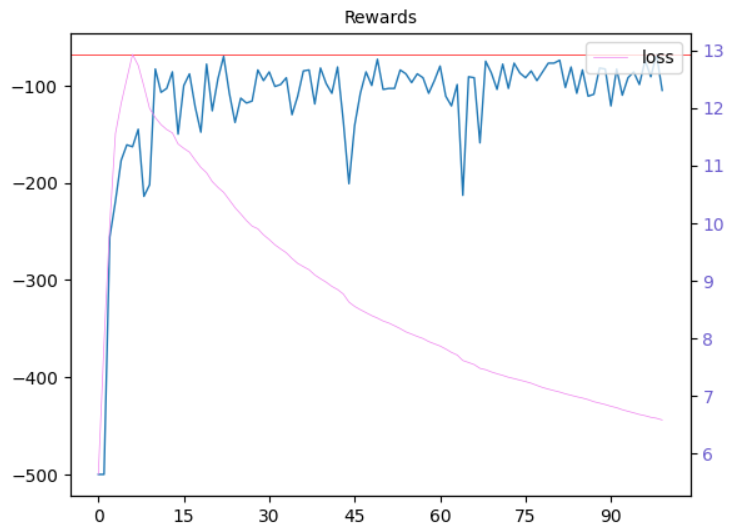

Moreover, large $\tau>0.05$ sometimes make the gradients explode, it breaks learning since it won't restore then

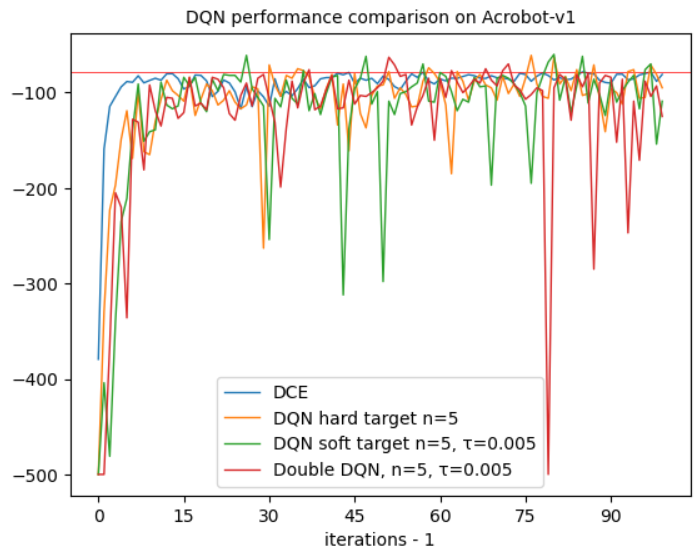

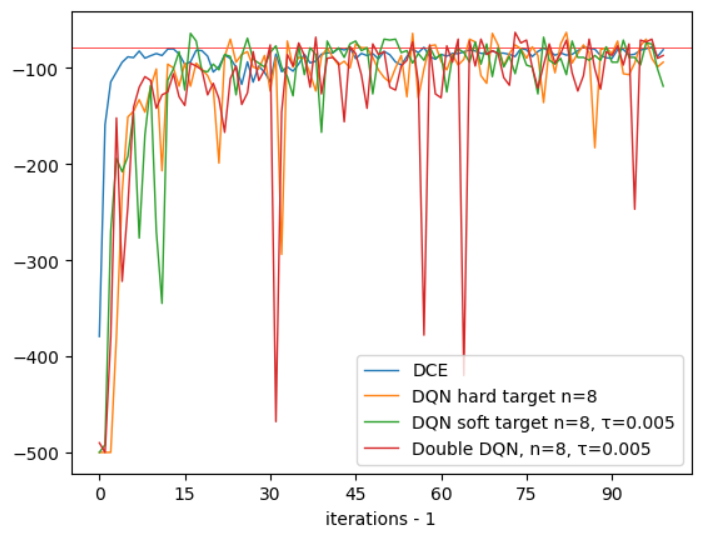

Note that my Cross-Entropy algorithm implementation contained sth similar to hard target with variable (increasing 1..max_n_epochs) number of epochs on each quantile chunk